# Data Exploration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Teeth DataSet.zip" -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Teeth_Dataset/Validation/CoS/b_111_0_6094.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/CoS/b_150_0_2905.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/OT/ot_1241_0_1157.jpg  
  inflating: /content/data/Teeth_Dataset/Validation/CoS/b_95 - Copy_0_6372.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/CaS/a_152_0_7749.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/CaS/a_126_0_9339.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/outputs/a_110_0_9820.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/outputs/a_141_0_7620.jpg  
  inflating: /content/data/Teeth_Dataset/Validation/CoS/b_132_0_2266.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/outputs/a_99_0_9803.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/OT/ot_1223_0_6812.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/OT/ot_1223_0_6082.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/output/

In [4]:
import os

# Base directory where your dataset was unzipped
BASE_DIR = '/content/data/Teeth_Dataset'

TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
VALID_DIR = os.path.join(BASE_DIR, 'Validation')
TEST_DIR  = os.path.join(BASE_DIR, 'Testing')

# Check the folder
os.listdir(TRAIN_DIR)


['OLP', 'OT', 'Gum', 'MC', 'OC', 'CoS', 'CaS']

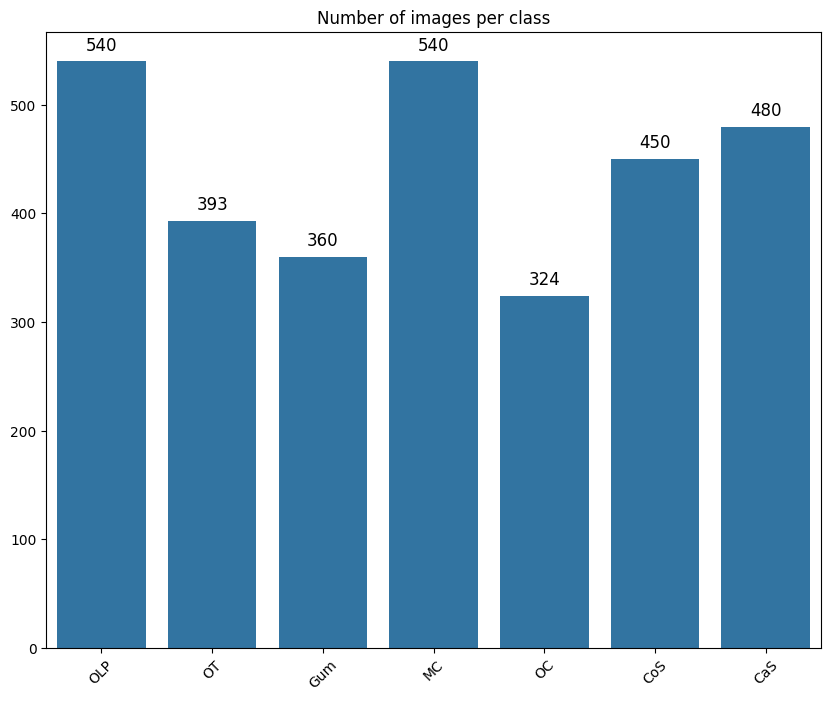

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
bars = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Number of images per class")

# Add counts on top of each bar
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),  # 5 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=12)

plt.show()


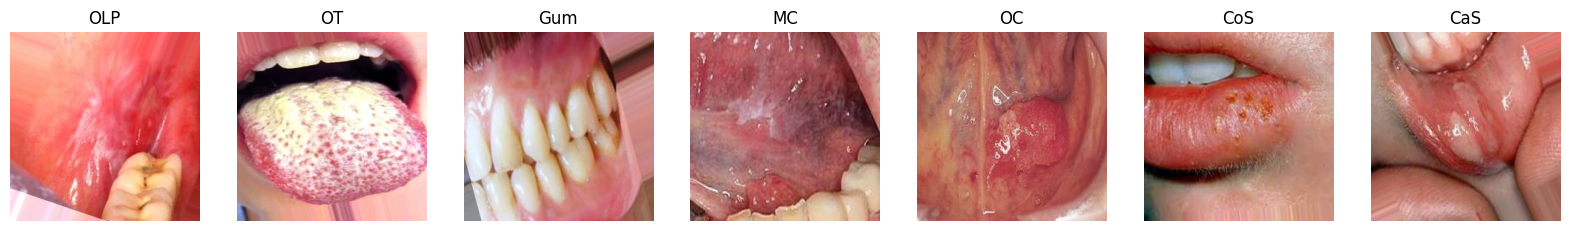

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,7,figsize=(20,10))
classes = os.listdir(TRAIN_DIR)

for i, class_name in enumerate(classes):
    class_folder = os.path.join(TRAIN_DIR, class_name)
    img_name = os.listdir(class_folder)[0]  # first image
    img_path = os.path.join(class_folder, img_name)

    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.show()


# Preprocessing

Define augmentation and normalization

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

Load dataset

In [18]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/Teeth_Dataset/Training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/Teeth_Dataset/Validation",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/Teeth_Dataset/Testing",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1508 files belonging to 10 classes.


Take one image from training

In [12]:
for images, labels in train_ds.take(1):
    original_image = images[0]

Visualize 9 augmented versions

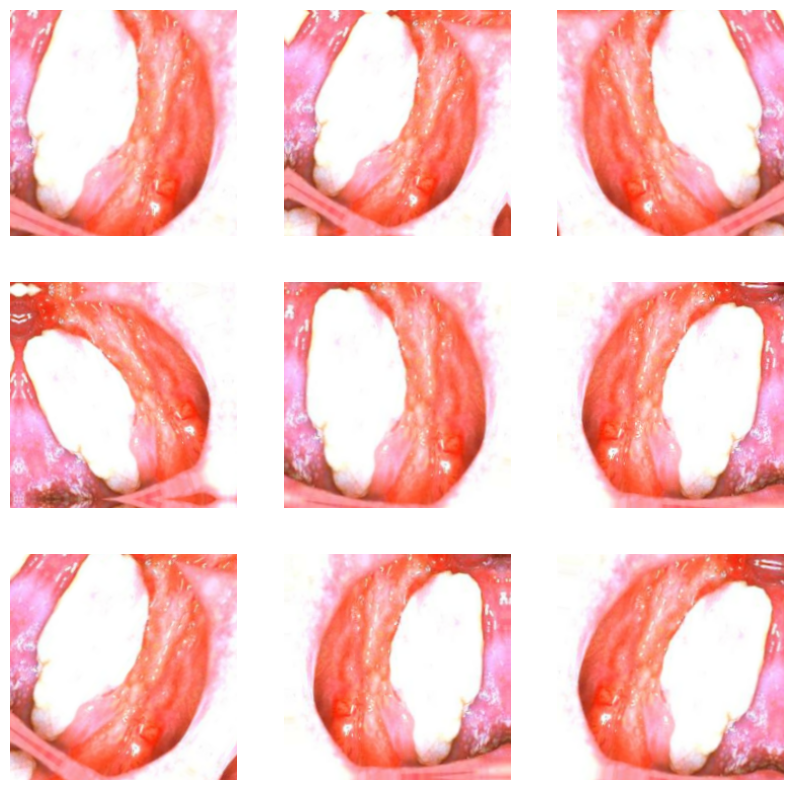

In [13]:
plt.figure(figsize=(10,10))

for i in range(9):
    # Apply augmentation
    augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training=True)

    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

plt.show()

# Build CNN Model

In [22]:
from tensorflow.keras import layers, models

def build_teeth_model_light(input_shape=(256,256,3), num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)

    # Preprocessing
    x = data_augmentation(inputs)
    x = normalization_layer(x)

    # Conv blocks
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Replace Flatten with GlobalAveragePooling2D
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers with Dropout
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model = build_teeth_model_light()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,423 (1.57 MB)

 Trainable params: 412,423 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
 9/97 ━━━━━━━━━━━━━━━━━━━━ 16:15 11s/step - accuracy: 0.1113 - loss: 1.9546

Evaluate on Test Set

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")